<center><h1>矩阵特征值计算：幂法与反幂法<h1/><center/>

## 实验内容
给定矩阵

$$
A = \begin{pmatrix}5&4&1&1\\4&5&1&1\\1&1&4&2\\1&1&2&4\end{pmatrix}
$$

(1)用幂法求$A$的主特征值及对应的特征向量，并用瑞利商加速方法观察加速效果

(2)利用反幂法迭代，使用不同的$p$值，求$A$的不同特征向量及特征向量.比较结果

## 实验原理
### 幂法

#### 迭代与收敛原理

对于初始向量$v_0\neq0$,设$x_i$是$A$的特征向量，$\lambda_i$是$A$的特征值
$$
v_0=\sum_{i=1}^n\alpha_i x_i
$$
构造迭代序列$\{v_k\}$与$\{u_k\}$

$$
u_0=v_0
$$

$$
v_k=Au_{k-1},u_k=\frac{v_k}{abs \max{\{v_k\}}}
$$

$$
\begin{aligned}
v_k
&=\frac{A^kv_0}{abs\max{\{A^{k-1}v_0\}}}\\
&=\frac{\sum_{i=1}^n\alpha_i \lambda_i^k x_i}{abs\max\{\sum_{i=1}^n\alpha_i \lambda_i^{k-1} x_i\}}\\
&=\lambda_1\frac{\alpha_1x_1+\sum_{i=2}^n\alpha_i (\frac{\lambda_i}{\lambda_1})^k x_i}{abs\max\{\alpha_1x_1+\sum_{i=2}^n\alpha_i (\frac{\lambda_i}{\lambda_1})^{k-1} x_i\}}\\
abs\max\{v_k\}&=\frac{\lambda_1abs\max\{\alpha_1x_1+\sum_{i=2}^n\alpha_i (\frac{\lambda_i}{\lambda_1})^k x_i\}}{abs\max\{\alpha_1x_1+\sum_{i=2}^n\alpha_i (\frac{\lambda_i}{\lambda_1})^{k-1} x_i\}}\rightarrow\lambda_1\quad(k\rightarrow \infty)
\end{aligned}
$$

#### 算法描述

对于给定的初始向量$v_0$与误差要求精度$\epsilon$
$$
u\leftarrow v_0,\lambda\leftarrow0
$$
loop

1. $v\leftarrow Au$
2. $u\leftarrow v/absmax(v)$
3. $\lambda'\leftarrow absmax(v),\Delta\lambda\leftarrow abs(\lambda'-\lambda)$
4. if $\Delta\lambda<\epsilon$, then return $\lambda'$
5. $\lambda\leftarrow\lambda'$

### 瑞利商加速

迭代序列与幂法一致
$$
v_k=Au_{k-1},u_k=\frac{v_k}{abs\max{\{v_k\}}}
$$

其区别在于$\lambda_1$的逼近表达式
$$
\lambda_1 \leftarrow \frac{(Au_k,u_k)}{(u_k,u_k)}\quad(k\rightarrow\infty)
$$

> 所以在编程中`幂法`与`瑞利商法`的代码除了$\lambda_1$的逼近表达式是一样的，所以可以将$\lambda_1$的逼近表达式作为参数传入，从而在一个函数中实现

### 反幂法

对于$p$，若$(A-pI)^{-1}$存在，其特征值为
$$
\frac1{\lambda_i-p}
$$
对应的特征向量为$x_i$

对$(A-pI)^{-1}$使用幂法
$$
\begin{cases}
u_0=v_0\neq0&v_0为初始向量\\
v_k=(A-pI)^{-1}u_{k-1}&k=1,2,\cdots\\
u_k=\frac{v_k}{abs\max{\{v_k\}}}
\end{cases}
$$
若$p \rightarrow \lambda_j$
$$
|\lambda_j-p|<<|\lambda_i-p|,\quad i\neq j
$$
$$
\left|\frac1{\lambda_j-p}\right|>\left|\frac1{\lambda_i-p}\right|,\quad\forall i\neq j
$$
说明$\frac1{\lambda_j-p}$是主特征值
$$
\frac1{\lambda_j-p}\leftarrow abs\max\{v_k\},\quad(k\rightarrow\infty)
$$
$$
\lambda_j\leftarrow p+\frac1{abs\max\{v_k\}},\quad(k\rightarrow\infty)
$$

## 编程实现
> 用Julia语言实现

先导入依赖和输入计算所需的数据

In [1]:
import Logging
Logging.disable_logging(Logging.Info)

using LinearAlgebra,Plots
plotly()

include("MatrixKit.jl");

@latex (macro with 3 methods)

### 幂法和瑞利商法求主特征值

In [2]:
absmax(v) = maximum(abs,v)
norm!(v) = v ./ absmax(v)

PowerλExpr(A,u,v) = absmax(v)
RayleighλExpr(A,u,v) = sum(A*u.*u)/sum(u.*u)

function MainEigen(A::Matrix;λexpr=PowerλExpr,u=NaN,digits=4,maxiter=100,reqλs=false)
    n = size(A)[1]
    u == NaN || (u = ones(n))  
    λ = 0.
    reqλs && (λs = Vector{Float64}())
    for i ∈ 1:maxiter
        v = A*u
        u = norm!(v)
        λ⁺ = λexpr(A,u,v)
        ok = false
        abs(λ⁺-λ) < .1^digits && (ok = true)
        λ = λ⁺
        reqλs && push!(λs,λ)
        if ok
            if reqλs
                return λ,u,λs
            end
            return λ,u
        end
    end
    (throw∘error)("Can't find solution satisfied precise demand within the maximum number of iterations.")
end

MainEigen (generic function with 1 method)

### 反幂法

In [3]:
function InvPowMethod(A::Matrix,p::Number;λexpr=PowerλExpr,u=NaN,digits=4,maxiter=100,reqλs=false)
    n = size(A)[1]
    u == NaN || (u = ones(n))
    B⁻¹ = inv(A - p*I)
    λ = 0.
    reqλs && (λs = Vector{Float64}())
    for i ∈ 1:maxiter
        v = B⁻¹*u
        u = norm!(v)
        λ⁺ = p+1/λexpr(B⁻¹,u,v)
        ok = false
        abs(λ⁺-λ) < .1^digits && (ok = true)
        λ = λ⁺
        reqλs && push!(λs,λ)
        if ok
            if reqλs
                return λ,u,λs
            end
            return λ,u
        end
    end
    (throw∘error)("Can't find solution satisfied precise demand within the maximum number of iterations.")
end

InvPowMethod (generic function with 1 method)

## 计算实例、数据、结果、比较
先输入数据

In [4]:
@latex A = [[5 4;4 5] ones(Int,2,2);ones(Int,2,2) [4 2;2 4]]

<center>$A=\begin{pmatrix}5&4&1&1\\4&5&1&1\\1&1&4&2\\1&1&2&4\end{pmatrix}$</center>


### 用幂法和瑞利商法计算主特征值
#### 计算

In [5]:
λ,v = MainEigen(A,λexpr=PowerλExpr)
@show λ;

λ = 10.000050863147614


In [6]:
@latex v T

<center>$v=\begin{pmatrix}1.0&1.0&0.5000127157222276&0.5000127157222276\end{pmatrix}$$^T$</center>


In [7]:
λ,v = MainEigen(A,λexpr=RayleighλExpr)
@show λ;

λ = 9.999991522909337


In [8]:
@latex v T

<center>$v=\begin{pmatrix}1.0&1.0&0.501628664495114&0.501628664495114\end{pmatrix}$$^T$</center>


#### 比较
这里按照题目要求对两种方法，进行比较

下面绘制收敛曲线，来比较一下两种算法收敛速度的差异

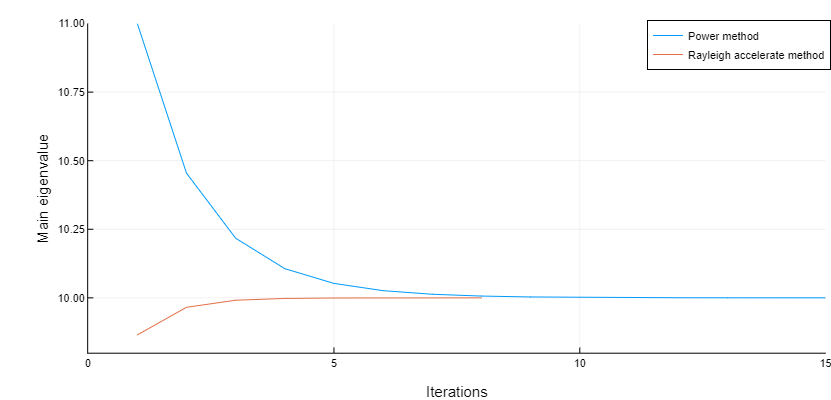

In [9]:
_,_,λsᴾ = MainEigen(A,λexpr=PowerλExpr,reqλs=true)
_,_,λsᴿ = MainEigen(A,λexpr=RayleighλExpr,reqλs=true)

plot(λsᴾ,label="Power method")
plot!(λsᴿ,label="Rayleigh accelerate method")

xlabel!("Iterations")
ylabel!("Main eigenvalue")
ylims!(9.8,11)
xlims!(0,15)

对比，可见`瑞利商加速法`比`幂法`更快更好地收敛

当然根据上面计算结果，和迭代公式，可以看出，`瑞利商`只加速了特征值的收敛，并没有加速特征向量的收敛

### 用反幂法，选取p，计算全部特征值

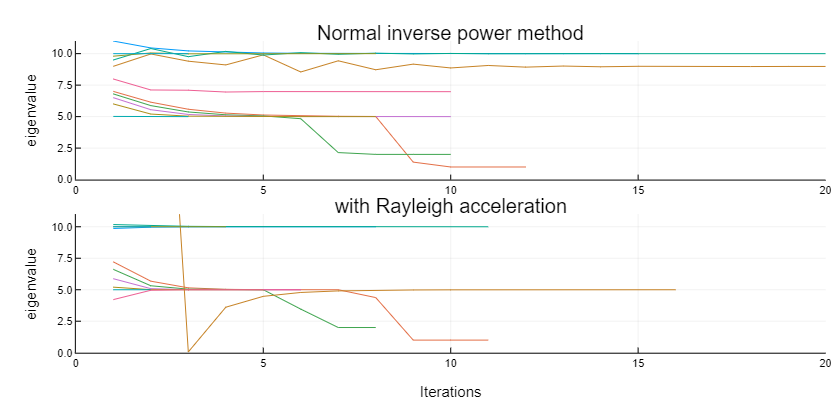

In [10]:
_,_,λsᴾ = MainEigen(A,λexpr=PowerλExpr,reqλs=true)
_,_,λsᴿ = MainEigen(A,λexpr=RayleighλExpr,reqλs=true)

plotᴾ = plot(λsᴾ,title="Normal inverse power method",label=false)
plotᴿ = plot(λsᴿ,title="with Rayleigh acceleration",label=false)

resultᴿ = Vector()

for p ∈ 1:10
    p -= .01
    _,_,λsᴾ = InvPowMethod(A,p,λexpr=PowerλExpr,reqλs=true)
    λ,v,λsᴿ = InvPowMethod(A,p,λexpr=RayleighλExpr,reqλs=true)
    push!(resultᴿ,(p=p,λ=λ,v=round.(v;digits=4)))
    plot!(plotᴾ,λsᴾ,label="p=$p")
    plot!(plotᴿ,λsᴿ,label="p=$p")
end

xlabel!(plotᴿ,"Iterations")
plot(plotᴾ,plotᴿ,layout = (2, 1),legend=false)
ylabel!("eigenvalue")
ylims!(0,11)
xlims!(0,20)

$A$为4阶矩阵，至多有4个不同的实特征值

`普通反幂法`取10个$p$计算，最终于收敛于6个解，其中必有不是特征值的解

`瑞利商加速反幂法`取10个$p$计算，最终于收敛于4个解，所以这4个解均是其特征值的数值近似解

可以看到，`普通反幂法`对$p$的选取较为敏感，只有$p$临近真实解时，从能收敛到真实解，可靠性差

In [11]:
using DataFrames

DataFrame(resultᴿ)

,p,λ,v
,Float64,Float64,Array…
1,0.99,1.0,"[1.0, -1.0, 0.0, 0.0]"
2,1.99,2.0,"[-0.0001, -0.0001, -0.9997, 1.0]"
3,2.99,5.0,"[-0.4979, -0.4979, 1.0, 1.0]"
4,3.99,5.0,"[-0.4995, -0.4995, 1.0, 1.0]"
5,4.99,5.0,"[-0.5, -0.5, 1.0, 1.0]"
6,5.99,5.0,"[-0.4992, -0.4992, 1.0, 1.0]"
7,6.99,4.99995,"[-0.495, -0.495, 1.0, 1.0]"
8,7.99,10.0001,"[1.0, 1.0, 0.4947, 0.4947]"
9,8.99,10.0,"[1.0, 1.0, 0.5017, 0.5017]"


> 以上输出结果为`瑞利商加速的反幂法`求解结果

观察可知,$A$的特征值与对应的特征向量

| $A$的特征值 $\lambda$ | 矩阵$A$的对应的特征向量  $v$      |
| :----------------: | :-------------------: |
| 1              | $[1,-1,0,0]^T$      |
| 2              | $[0,0,-1,1]^T$      |
| 5              | $[0.5,0.5,-1,-1]^T$ |
| 10            | $[0.5,0.5,1,1]^T$   |

## 结果分析

实验结果与理论基本相符

1. 在求主特征值问题上，`幂法`与`瑞利商加速法`都可以较为准确的主特征值与向量，且`瑞利商加速法`速度更快
2. 在反幂法求全部特征值问题上，`普通反幂法`对$p$的选取较为敏感，只有$p$临近真实解时，从能收敛到真实解，可靠性差；而`瑞利商加速的反幂法`却可以更好更快的求解，可靠性较好

## 结尾

放个动画彩蛋,展示一下`反幂法`动态收敛效果

Plots.AnimatedGif("C:\\Users\\CreatorFan\\Documents\\Course\\Numerial Analysis\\Julia\\tmp.gif")
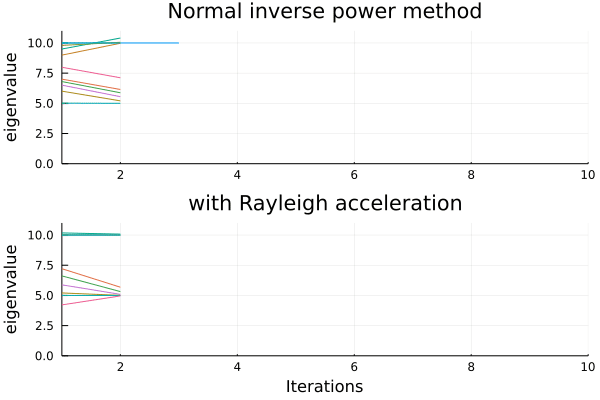

In [12]:
gr()

function cut(array,from,to)
    try
        array[from:to]
    catch 
        array[from:end]
    end
end

@gif for i ∈ 2:25
    plotᴾ = plot(λsᴾ,title="Normal inverse power method",label=false)
    plotᴿ = plot(λsᴿ,title="with Rayleigh acceleration",label=false)

    for p ∈ 1:10
        p -= .01
        _,_,λsᴾ = InvPowMethod(A,p,λexpr=PowerλExpr,reqλs=true)
        _,_,λsᴿ = InvPowMethod(A,p,λexpr=RayleighλExpr,reqλs=true)
        plot!(plotᴾ,cut(λsᴾ,1,i),label="p=$p")
        plot!(plotᴿ,cut(λsᴿ,1,i),label="p=$p")
    end
    
    xlabel!(plotᴿ,"Iterations")
    plot(plotᴾ,plotᴿ,layout = (2, 1),legend=false)
    ylabel!("eigenvalue")
    ylims!(0,11)
    xlims!(1,i > 10 ? i : 10)
end